# Advanced Simulation Modeling

## LAB 03: CASE STUDY - INSURANCE COMPANY



<table>
<tr></tr>
<tr><td>

| **Insurance company**
|----------------
| Initial balance = 10 000 USD
| Initial insurance premium = 500 USD
| Number of damages ~ Poisson 
| Damage size ~ Lognormal
| #TODO
| - Find optimal insurance premium value
| - Estimate bankruptcy probabilities
| - Find optimal initial balance and insurance premium for bankruptcy probabilitiy less than 0.1
    
</td><td>


<table>
<tr></tr>
<tr><td>

| Number of damages    | Number of insurance policies
|-----------------|-------------
| 0               | 3 437
| 1               | 522
| 2               | 40
| 3               | 2
| 4               | 0
| 5               | 0

</td><td>

| Damage size | Number of damages 
|-----------------|-------------
| -               | 0
| 100             | 0
| 200             | 2
| 500             | 27
| 1 000           | 52
| 2 000           | 115
| 5 000           | 203
| 10 000          | 106
| 20 000          | 42
| 40 000          | 14
| 50 000          | 0
| 55 000          | 0
| 60 000          | 1

</td></tr> </table>


`Poisson distribution` - a discrete probability distribution that expresses the probability of a given number of events occurring in a fixed interval of time or space

`Log-normal distribution` - a continuous probability distribution of a random variable whose logarithm is normally distributed

## SOLUTION


In [2]:
import csv
import scipy as sc
import matplotlib.pyplot as plt

from scipy.stats.stats import kstest

## 1. DATA - DISTRIBUTIONS, PARAMETERS

### Number of damages

<BarContainer object of 6 artists>

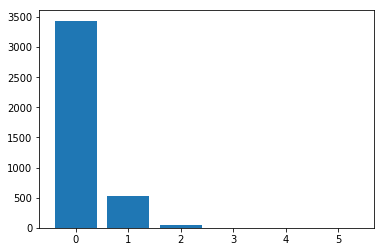

In [3]:
number_of_damages = {0 : 3437, 
                     1 : 522, 
                     2 : 40, 
                     3 : 2, 
                     4 : 0, 
                     5 : 0}

plt.bar(list(number_of_damages.keys()), 
        list(number_of_damages.values()))

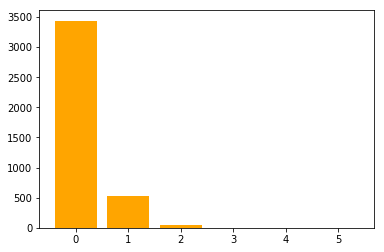

In [4]:
# average number of damages:
number_of_damages_avg = (sum([x * y for x, y in number_of_damages.items()]) / 
                         sum(number_of_damages.values()))

# number of damages ~ Poisson?
poisson_test = [sc.stats.poisson.pmf(i, number_of_damages_avg) * 
                sum(number_of_damages.values()) for i in range(len(number_of_damages))]

plt.bar(list(number_of_damages.keys()), poisson_test, color = "orange")
plt.show()

In [5]:
# chi-squared test:
# H0: number of damages follows a Poisson distribution
# H0: number of damages does not follow a Poisson distribution

test1 = sc.stats.chisquare(list(number_of_damages.values()), f_exp = poisson_test)
if test1[1] > 0.05:
    print ("fail to reject the null hypothesis")
else:
    print("null hypothesis should be rejected")

fail to reject the null hypothesis


### Damage size

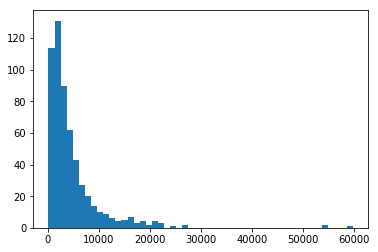

Average damage size: 4742.0


In [6]:
damages = []
with open('damages.txt','r') as csvfile:
    reader = csv.reader (csvfile, delimiter=";")
    for row in reader:
        damages.append(int(row[1]))

plt.hist(damages, bins=50)
plt.show()

print ("Average damage size:", round(sc.mean(damages))) 

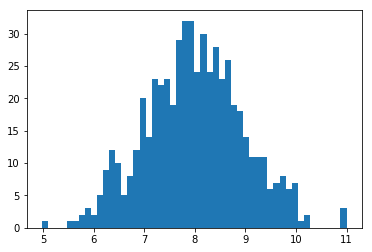

In [7]:
# damages size ~ Lognormal?
damages_ln = sc.log(damages)

plt.hist(damages_ln, bins=50)
plt.show()        

In [8]:
# test K-S
test2 = kstest(damages_ln, sc.stats.norm.cdf, 
               args = (sc.mean(damages_ln), sc.std(damages_ln)))
if test2[1] > 0.05:
    print ("p-value: ", round(test2[1], 4), 
           "- fail to reject the null hypothesis")
else:
    print("null hypothesis should be rejected")

p-value:  0.9979 - fail to reject the null hypothesis


In [9]:
# simulation parameters
damages_ln_avg = sc.mean(damages_ln)
damages_ln_std = sc.std(damages_ln)
number_of_policies = 1500
number_of_damages_avg
time_horizon = 2
balance = 10000
insurance_premium = 500

## 2. SIMULATION MODEL

In [10]:
def model (number_of_policies, number_of_damages_avg, 
           damages_ln_avg, damages_ln_std, time_horizon, 
           balance, insurance_premium, seed):
    
    # Common Random Numbers:
    # sc.random.seed(seed) 

    # contracts signing calendar:
    dates = [sc.random.randint(0, 364) for i in range(number_of_policies)]
    calendar_contracts = [0]*365
    for day in dates:
        calendar_contracts[day] += 1

    # number of damages per one policy:
    number_of_damages = sc.random.poisson(number_of_damages_avg, 
                                          number_of_policies)
    
    # compensations calendar:
    calendar_compensations = [0]*(365*time_horizon) 
    for k in range(number_of_policies):
        for s in range(number_of_damages[k]):
            compensation_date = dates[k] + sc.random.randint(0, 364)
            calendar_compensations[compensation_date] += 1
    
    
    # time_horizon simulation:
    for day in range(365*time_horizon):
        if day <= 364:
            balance += calendar_contracts[day] * insurance_premium
        
        number_of_compensations = calendar_compensations[day]
        compensations = 0 
        if number_of_compensations > 0:
            compensations = sum(sc.exp(sc.random.normal(damages_ln_avg, 
                                                        damages_ln_std, 
                                                        number_of_compensations)))
        if balance < compensations:
            return balance - compensations
        else:
            pass
        balance -= compensations
    return balance

### ... and `run()` function

In [11]:
def run(balance, insurance_premium, repeats, 
        number_of_policies, number_of_damages_avg , 
        damages_ln_avg, damages_ln_std, time_horizon):
    
    results = []
    bankruptcy = 0
    results_positve = []
    
    for seed in range(repeats):
        results.append(model(number_of_policies, number_of_damages_avg , 
                           damages_ln_avg, damages_ln_std, time_horizon, 
                           balance, insurance_premium, seed))
        if results[seed] < 0:
            bankruptcy += 1
        if results[seed] > 0:
            results_positve.append(results[seed])
            
    results_average = sc.mean(results_positve)
    bankruptcy_risk = bankruptcy / repeats
    
    return [bankruptcy, bankruptcy_risk, results_average]

## 3. SIMULATION RESULTS

BALANCE:  10000 INSURANCE PREMIUM:  500 BANKRUPTCY CNT:  99 AVERAGE RESULT:  2538.0 BANKRUPTCY RISK:  0.99
BALANCE:  10000 INSURANCE PREMIUM:  600 BANKRUPTCY CNT:  91 AVERAGE RESULT:  50578.0 BANKRUPTCY RISK:  0.91
BALANCE:  10000 INSURANCE PREMIUM:  700 BANKRUPTCY CNT:  59 AVERAGE RESULT:  90672.0 BANKRUPTCY RISK:  0.59
BALANCE:  10000 INSURANCE PREMIUM:  800 BANKRUPTCY CNT:  10 AVERAGE RESULT:  172941.0 BANKRUPTCY RISK:  0.1
BALANCE:  10000 INSURANCE PREMIUM:  900 BANKRUPTCY CNT:  1 AVERAGE RESULT:  283748.0 BANKRUPTCY RISK:  0.01


/Users/valkoiset/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/valkoiset/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


BALANCE:  20000 INSURANCE PREMIUM:  500 BANKRUPTCY CNT:  100 AVERAGE RESULT:  nan BANKRUPTCY RISK:  1.0
BALANCE:  20000 INSURANCE PREMIUM:  600 BANKRUPTCY CNT:  93 AVERAGE RESULT:  55517.0 BANKRUPTCY RISK:  0.93
BALANCE:  20000 INSURANCE PREMIUM:  700 BANKRUPTCY CNT:  48 AVERAGE RESULT:  82516.0 BANKRUPTCY RISK:  0.48
BALANCE:  20000 INSURANCE PREMIUM:  800 BANKRUPTCY CNT:  7 AVERAGE RESULT:  175081.0 BANKRUPTCY RISK:  0.07
BALANCE:  20000 INSURANCE PREMIUM:  900 BANKRUPTCY CNT:  1 AVERAGE RESULT:  259922.0 BANKRUPTCY RISK:  0.01
BALANCE:  30000 INSURANCE PREMIUM:  500 BANKRUPTCY CNT:  100 AVERAGE RESULT:  nan BANKRUPTCY RISK:  1.0
BALANCE:  30000 INSURANCE PREMIUM:  600 BANKRUPTCY CNT:  88 AVERAGE RESULT:  40460.0 BANKRUPTCY RISK:  0.88
BALANCE:  30000 INSURANCE PREMIUM:  700 BANKRUPTCY CNT:  37 AVERAGE RESULT:  87464.0 BANKRUPTCY RISK:  0.37
BALANCE:  30000 INSURANCE PREMIUM:  800 BANKRUPTCY CNT:  10 AVERAGE RESULT:  171588.0 BANKRUPTCY RISK:  0.1
BALANCE:  30000 INSURANCE PREMIUM:  

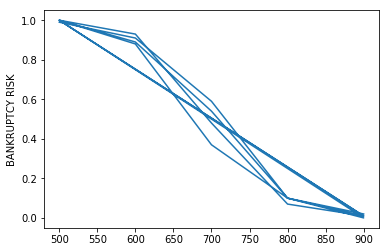

In [12]:
# model_parameters
results = [] # średni wynik finansowy firmy
insurance_cost = []
bankruptcy_risk = []
bankruptcy_cnt = [] 

repeats = 100
number_of_policies = 1500
time_horizon = 2 # 2 years


for balance in range(10000, 50000,10000):
    for insurance_premium in range(500,1000,100):
        run_result = run(balance, insurance_premium, repeats, 
                         number_of_policies, number_of_damages_avg, 
                         damages_ln_avg, damages_ln_std, time_horizon)
        
        insurance_cost.append(insurance_premium)
        bankruptcy_cnt.append(run_result[0])
        bankruptcy_risk.append(run_result[1])
        results.append(run_result[2])
        
        print("BALANCE: ", balance, "INSURANCE PREMIUM: ", insurance_premium, 
              "BANKRUPTCY CNT: ", run_result[0], "AVERAGE RESULT: ", round(run_result[2]), 
              "BANKRUPTCY RISK: ", run_result[1])

plt.plot(insurance_cost, bankruptcy_risk)
plt.ylabel('BANKRUPTCY RISK')
plt.show()

Conclusion:
After running simulation with 100 repeats and 1500 policies we can clearly see that the there are few scenarios of the lowest bankruptcy risk:
* bankruptcy risk = 0.2/0.1: balance - 10000, insurance premium - 800/900
* bankruptcy risk = 0.01: balance - 20000, insurance premium - 900
* bankruptcy risk = 0.01: balance - 30000, insurance premium - 900
* bankruptcy risk = 0.01: balance - 40000, insurance premium - 900

Interestingly, that when balance is 20000/30000 but insurance premium is 500/600, bankruptcy risk ~ 0.9